In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import matplotlib.pyplot as plt

**Method 1: Sequential**

In [2]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10)
)

**Method 2: Class-based (more flexible)**

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], num_classes=10, dropout=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.linear_stack = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

In [4]:
model = NeuralNetwork(input_size=784, hidden_sizes=[128, 64], num_classes=10)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [5]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 109,386
Trainable parameters: 109,386


**Training Loop**

In [6]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [7]:
# Load data (MNIST example)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess
x_train = x_train.reshape(x_train.shape[0], 784).astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], 784).astype('float32') / 255.0

In [8]:
# Prepare data
train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [9]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [12]:
num_epochs = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Forward
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    # Calculate averages
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/10:
  Train Loss: 0.4983, Train Acc: 85.24%
  Val Loss: 0.1923, Val Acc: 94.26%
  LR: 0.001000
Epoch 2/10:
  Train Loss: 0.2085, Train Acc: 93.90%
  Val Loss: 0.1391, Val Acc: 95.81%
  LR: 0.001000
Epoch 3/10:
  Train Loss: 0.1577, Train Acc: 95.25%
  Val Loss: 0.1176, Val Acc: 96.35%
  LR: 0.001000
Epoch 4/10:
  Train Loss: 0.1261, Train Acc: 96.27%
  Val Loss: 0.0906, Val Acc: 97.14%
  LR: 0.001000
Epoch 5/10:
  Train Loss: 0.1096, Train Acc: 96.68%
  Val Loss: 0.0847, Val Acc: 97.35%
  LR: 0.001000
Epoch 6/10:
  Train Loss: 0.0956, Train Acc: 97.09%
  Val Loss: 0.0825, Val Acc: 97.56%
  LR: 0.001000
Epoch 7/10:
  Train Loss: 0.0874, Train Acc: 97.32%
  Val Loss: 0.0737, Val Acc: 97.71%
  LR: 0.001000
Epoch 8/10:
  Train Loss: 0.0767, Train Acc: 97.67%
  Val Loss: 0.0737, Val Acc: 97.73%
  LR: 0.001000
Epoch 9/10:
  Train Loss: 0.0715, Train Acc: 97.84%
  Val Loss: 0.0729, Val Acc: 97.76%
  LR: 0.001000
Epoch 10/10:
  Train Loss: 0.0659, Train Acc: 97.93%
  Val Loss: 0.0725, 

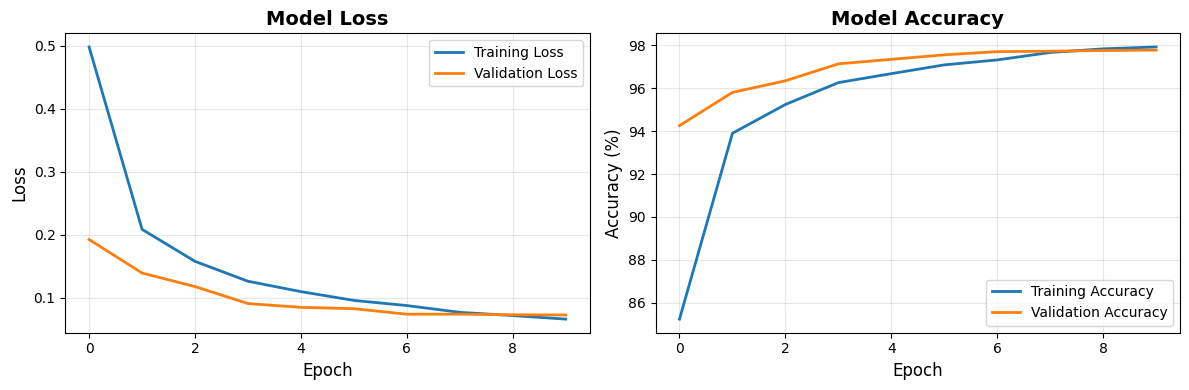

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()